## Task 1: Calculate the acoplanary angles

Before any traning, let's try and reconstruct aco_angle_1 from the low level variable. 
$\mathbf{\lambda}^{\pm}=(0,\mathbf{j}^\pm)$ where $\mathbf{j}^\pm$ is the impact parameter vector defined as the vector btw the primary vertex (PV) and the point of closest approach (PCA).

Then we need to boost $\mathbf{\lambda}^{\pm}$ into the zero momentum frame (ZMF) thus giving $\mathbf{\lambda}^{*\pm}$. I will need to code a function to boost any four vector into the pion's ZMF. 

We will also need $\mathbf{q}^{*\pm}$ are the four-vector for charged pions, boosted in the ZMF. 

After that we will calculate $\mathbf{\lambda}^{*\pm}_{\perp}$ the transverse component of $\mathbf{\lambda}^{*\pm}$ w.r.t. $\mathbf{q}^{*\pm}$. 

Finally, the acoplanary angle $\phi_{CP}$ is definied by 

$\phi_{\mathrm{CP}}=\left\{\begin{array}{ll} \phi^{*} &  \text { if } O^{*} \geq 0 \\  360^{\circ}-\phi^{*} & \text { if } O^{*}<0 \end{array}\right\}$

$\phi^{*}=\arccos \left(\hat{\lambda}_{\perp}^{*+} \cdot \hat{\lambda}_{\perp}^{*-}\right)$

with $O^{*}=\hat{q}^{*-} \cdot\left(\hat{\lambda}_{\perp}^{*+} \times \hat{\lambda}_{\perp}^{*-}\right)$.


Start with $\mathbf{j}^\pm$, check what we have in terms of available informations.

In [67]:
!pip install --user uproot
import sys
sys.path.append("/eos/home-m/acraplet/.local/lib/python2.7/site-packages")

In [68]:
import uproot 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt


In [69]:
# loading the tree
tree = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
tree2 = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]


#These are new trees, added by Danny on 13/10
tree3=uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]  
#note, instead of the first t we can have e,m, different decay modes

In [70]:
# The impact parameter vector for the leading and sub-leading are given by ip_{x,y,z}_{1,2}

#ip_sig_{1,2} gives the significance of the impact paramter, will be usefull in future.

#Now define a new panda dataframe, which I'll only use to get out the acoplanary angle
#using low level variables (maybe we'll need to reconstruct the impact parameter vector 
#as well but I don't think that this is usefull just yet).

variables4 = ["ip_x_1","ip_y_1","ip_z_1",
              "ip_x_2","ip_y_2","ip_z_2",
              "aco_angle_1", "aco_angle_6", "aco_angle_5", "aco_angle_7", 
              "pi_E_1","pi_px_1","pi_py_1","pi_pz_1",
              "pi_E_2","pi_px_2","pi_py_2","pi_pz_2",
              "tau_decay_mode_1","tau_decay_mode_2",
              "mva_dm_1","mva_dm_2",
              "pi0_E_1","pi0_px_1","pi0_py_1","pi0_pz_1",
              "pi0_E_2","pi0_px_2","pi0_py_2","pi0_pz_2",
              "y_1_1","y_1_2",
              "rand","wt_cp_sm", "wt_cp_ps", "wt_cp_mm"
              
             ]


df4 = tree.pandas.df(variables4)

df4 = df4[
      (df4["tau_decay_mode_1"] == 1) 
    & (df4["tau_decay_mode_2"] == 1) 
    & (df4["mva_dm_1"] == 1) 
    & (df4["mva_dm_2"] == 1)
]



df_ps = df4[
      (df4["rand"]<df4["wt_cp_ps"]/2)     #a data frame only including the pseudoscalars
]

df_sm = df4[
      (df4["rand"]<df4["wt_cp_sm"]/2)     #data frame only including the scalars
]


#keep that ??    

#note: maybe we'll have to apply some cuts, to not get the a1 for example whose 
# decays are more complicated


In [71]:
#Let's try and use the pylorentz module for performing boosts
# more info: https://gitlab.sauerburger.com/frank/pylorentz/-/blob/master/pylorentz/__init__.py

!pip install --user pylorentz
import sys
sys.path.append("/eos/home-a/acraplet/.local/lib/python2.7/site-packages")

from pylorentz import Momentum4
from pylorentz import Vector4
from pylorentz import Position4

In [72]:
#Some geometrical functions

def cross_product(vector3_1,vector3_2):
    if len(vector3_1)!=3 or len(vector3_1)!=3:
        print('These are not 3D arrays !')
    x_perp_vector=vector3_1[1]*vector3_2[2]-vector3_1[2]*vector3_2[1]
    y_perp_vector=vector3_1[2]*vector3_2[0]-vector3_1[0]*vector3_2[2]
    z_perp_vector=vector3_1[0]*vector3_2[1]-vector3_1[1]*vector3_2[0]
    return np.array([x_perp_vector,y_perp_vector,z_perp_vector])

def dot_product(vector1,vector2):
    if len(vector1)!=len(vector2):
        raise Arrays_of_different_size
    prod=0
    for i in range(len(vector1)):
        prod=prod+vector1[i]*vector2[i]
    return prod


def norm(vector):
    if len(vector)!=3:
        print('This is only for a 3d vector')
    return np.sqrt(vector[0]**2+vector[1]**2+vector[2]**2)

In [73]:
#Look only the sm like model
df4=df_sm

#Charged and neutral pion momenta
pi_1_4Mom=Momentum4(df4["pi_E_1"],df4["pi_px_1"],df4["pi_py_1"],df4["pi_pz_1"])
pi_2_4Mom=Momentum4(df4["pi_E_2"],df4["pi_px_2"],df4["pi_py_2"],df4["pi_pz_2"])

#Same for the pi0
pi0_1_4Mom=Momentum4(df4["pi0_E_1"],df4["pi0_px_1"],df4["pi0_py_1"],df4["pi0_pz_1"])
pi0_2_4Mom=Momentum4(df4["pi0_E_2"],df4["pi0_px_2"],df4["pi0_py_2"],df4["pi0_pz_2"])

In [74]:
#This is the COM frame of the two charged pions w.r.t. which we'll boost
ref_COM_4Mom=Momentum4(pi_1_4Mom+pi_2_4Mom)


#Lorentz boost everything in the ZMF of the two charged pions
pi0_1_4Mom_star=pi0_1_4Mom.boost_particle(-ref_COM_4Mom)
pi0_2_4Mom_star=pi0_2_4Mom.boost_particle(-ref_COM_4Mom)

#Lorentz boost everything in the ZMF of the two neutral pions
pi_1_4Mom_star=pi_1_4Mom.boost_particle(-ref_COM_4Mom)
pi_2_4Mom_star=pi_2_4Mom.boost_particle(-ref_COM_4Mom)

impact_param_1 = Momentum4(np.zeros(len(df4["ip_x_1"])),df4["ip_x_1"],df4["ip_y_1"],df4["ip_z_1"])
impact_param_2 = Momentum4(np.zeros(len(df4["ip_x_2"])),df4["ip_x_2"],df4["ip_y_2"],df4["ip_z_2"])

#pi0_1_4Mom_star = impact_param_1
#pi0_2_4Mom_star = impact_param_2

#Up to here I agree with Kingsley
(pi_1_4Mom_star+pi_2_4Mom_star)[:,23]

array([-3.15513367e+01, -2.13162821e-14,  2.84217094e-14, -1.56319402e-13])

In [75]:
#calculating the perpependicular component
pi0_1_3Mom_star_perp=cross_product(pi0_1_4Mom_star[1:],pi_1_4Mom_star[1:])
pi0_2_3Mom_star_perp=cross_product(pi0_2_4Mom_star[1:],pi_2_4Mom_star[1:])


#Now normalise:
pi0_1_3Mom_star_perp=pi0_1_3Mom_star_perp/norm(pi0_1_3Mom_star_perp)
pi0_2_3Mom_star_perp=pi0_2_3Mom_star_perp/norm(pi0_2_3Mom_star_perp)

#Up to here I agree with Kingsley
print(pi0_1_3Mom_star_perp[:,23])


[ 0.93642937  0.32724768 -0.12652663]


In [79]:
#Calculating phi_star
phi_CP=np.arccos(dot_product(pi0_1_3Mom_star_perp,pi0_2_3Mom_star_perp))

#Up to here I agree with Kingsley
print(phi_CP[23])

#The energy ratios
y_T = np.array(df4['y_1_1']*df4['y_1_2'])

#Up to here I agree with Kingsley
print(phi_CP[:10],'\n')

#The O variable
cross=np.cross(pi0_1_3Mom_star_perp.transpose(),pi0_2_3Mom_star_perp.transpose()).transpose()
bigO=dot_product(pi_2_4Mom_star[1:],cross)

print(bigO[:10], 'this is big O')

#perform the shift w.r.t. O* sign
phi_CP=np.where(bigO>=0, 2*np.pi-phi_CP, phi_CP)#, phi_CP)

print(phi_CP, 'this is after the first shift ')


#additionnal shift that needs to be done do see differences between odd and even scenarios, with y=Energy ratios
#phi_CP=np.where(y_T<0, 2*np.pi-phi_CP, np.pi-phi_CP)
phi_CP=np.where(y_T>=0, np.where(phi_CP<np.pi, phi_CP+np.pi, phi_CP-np.pi), phi_CP)


#Be carefull about shifting, works but different from Danny's way of doing  it and from the paper's way of doing it

print(phi_CP[:10],'\n')


0.879998067863984
[1.26777924 0.12206032 3.05769998 2.24701039 1.91653848 1.50376009
 2.42143725 0.19904402 0.9806288  1.49810879] 

[  7.40907046   1.21305234  -1.45438051 -22.63240115 -25.17376421
 -19.35485728   3.69476318   1.94323451 -34.89823966 -13.33622219] this is big O
[5.01540607 6.16112499 3.05769998 ... 3.84250578 0.8787811  4.54801936] this is after the first shift 
[5.01540607 3.01953234 3.05769998 5.38860304 5.05813113 4.64535275
 3.86174806 6.08414129 4.12222146 4.63970144] 



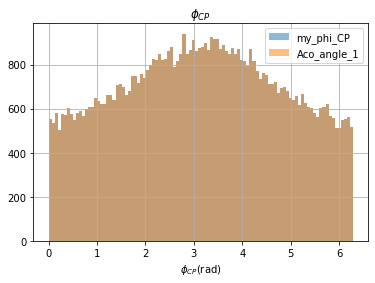

In [77]:
#now plot distribution
plt.figure()
plt.hist(phi_CP,bins=100, alpha=0.5,label='my_phi_CP')
plt.hist(df4['aco_angle_1'],bins=100, alpha=0.5,label='Aco_angle_1')
plt.title('$\phi_{CP}$')
plt.grid()
plt.xlabel('$\phi_{CP}$(rad)')
plt.legend()
#plt.savefig('phi_cp_hist.png')


In [78]:
#Checking the fraction of rights
difference=df4['aco_angle_1']-phi_CP

k=np.where(difference<=10**(-10),1,0)
print('Fraction of well reconstructed angle:',np.sum(k)/len(k))

Fraction of well reconstructed angle: 1.0
